In [ ]:
# Install necessary libraries (if not already installed in Colab's environment)
# !pip install opencv-python opencv-contrib-python matplotlib numpy tensorflow

# Import common libraries
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import os
import requests # For downloading datasets if needed
import tarfile # For extracting datasets
from tensorflow.keras.datasets import mnist, cifar10
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, Dropout, BatchNormalization, Input, Add, ReLU, DepthwiseConv2D, GlobalAveragePooling2D, UpSampling2D, Concatenate
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow.keras.applications import MobileNet, MobileNetV2, MobileNetV3Small, MobileNetV3Large
from sklearn.model_selection import train_test_split # For splitting datasets if needed
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.utils import to_categorical # For GAN label processing

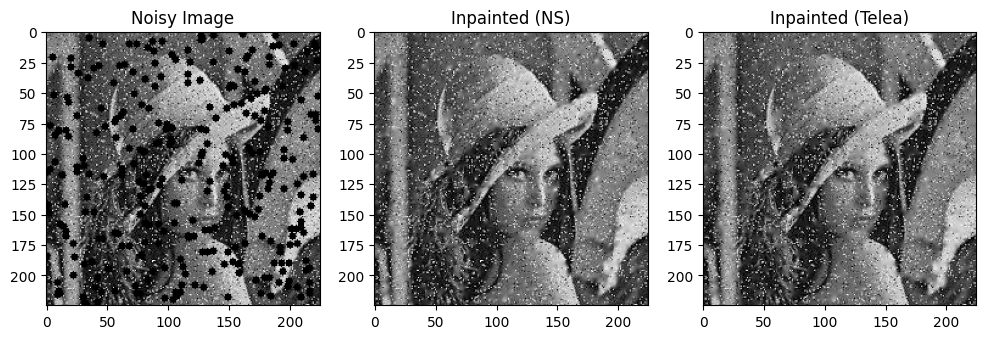

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load a real image
img = cv2.imread('/content/1.jpeg')  # Replace with your actual image path
if img is None:
    raise FileNotFoundError("Image not found. Please check the file path.")

# Create a mask manually (simulate damaged areas or use pre-defined mask)
mask = np.zeros(img.shape[:2], dtype=np.uint8)

# Example: Add fake noise manually (simulate damage/noise)
for i in range(300):  # Increase or decrease based on your needs
    x = np.random.randint(0, img.shape[1])
    y = np.random.randint(0, img.shape[0])
    cv2.circle(img, (x, y), 3, (0, 0, 0), -1)
    cv2.circle(mask, (x, y), 3, 255, -1)

# Inpaint using Navier-Stokes and Telea
inpainted_ns = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_NS)
inpainted_telea = cv2.inpaint(img, mask, inpaintRadius=3, flags=cv2.INPAINT_TELEA)

# Show results
plt.figure(figsize=(12, 5))
plt.subplot(131), plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB)), plt.title('Noisy Image')
plt.subplot(132), plt.imshow(cv2.cvtColor(inpainted_ns, cv2.COLOR_BGR2RGB)), plt.title('Inpainted (NS)')
plt.subplot(133), plt.imshow(cv2.cvtColor(inpainted_telea, cv2.COLOR_BGR2RGB)), plt.title('Inpainted (Telea)')
plt.show()


Loading images: /content/stitch1.jpg, /content/stitch2.jpg, /content/stitch3.jpg

Successfully loaded 3 images.
Combining images horizontally...
Images combined successfully!


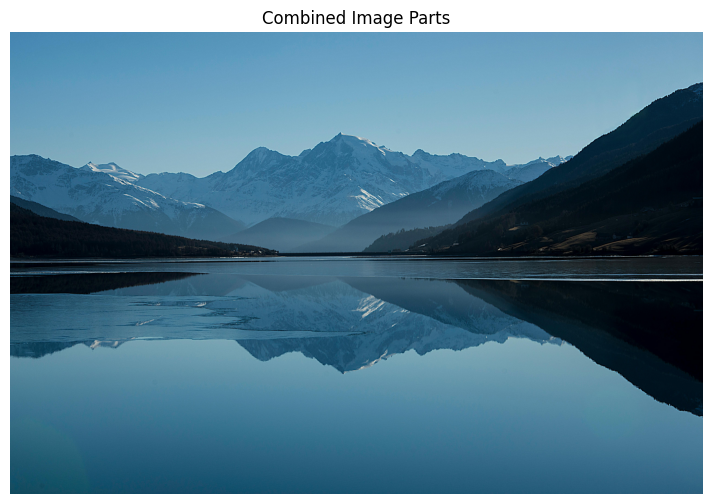

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# --- Combine Image Parts (Concatenation) ---

# Define the paths to your image parts IN THE CORRECT ORDER (e.g., left-to-right)
# Adjust the order if your parts are arranged differently (e.g., top-to-bottom)
image_paths = ['/content/stitch1.jpg', '/content/stitch2.jpg', '/content/stitch3.jpg']
axis_to_join = 1 # 1 for horizontal (left-to-right), 0 for vertical (top-to-bottom)

# Check if files exist before trying to load
missing_files = [path for path in image_paths if not os.path.exists(path)]
if missing_files:
    print(f"Error: The following image files were not found: {', '.join(missing_files)}")
    print("Please upload the images to the specified paths.")
    images = []
else:
    # Load images
    print(f"Loading images: {', '.join(image_paths)}")
    images = [cv2.imread(path) for path in image_paths]

# Check if all images were loaded successfully
if not images or any(img is None for img in images):
    print("\nError loading one or more images. Please ensure the paths are correct and the files are valid images.")
elif len(images) < 2:
     print("\nError: Need at least two images to combine.")
else:
    print(f"\nSuccessfully loaded {len(images)} images.")

    # --- Perform Concatenation ---
    try:
        if axis_to_join == 1: # Horizontal concatenation
            # Check if heights match for horizontal stacking
            heights = [img.shape[0] for img in images]
            if len(set(heights)) > 1:
                print(f"Warning: Image heights are different ({heights}). Resizing images to the smallest height for horizontal stacking.")
                min_height = min(heights)
                images_resized = [cv2.resize(img, (int(img.shape[1] * min_height / img.shape[0]), min_height)) for img in images]
                combined_image = np.hstack(images_resized)
            else:
                 print("Combining images horizontally...")
                 combined_image = np.hstack(images) # hstack joins arrays horizontally

        elif axis_to_join == 0: # Vertical concatenation
             # Check if widths match for vertical stacking
            widths = [img.shape[1] for img in images]
            if len(set(widths)) > 1:
                print(f"Warning: Image widths are different ({widths}). Resizing images to the smallest width for vertical stacking.")
                min_width = min(widths)
                images_resized = [cv2.resize(img, (min_width, int(img.shape[0] * min_width / img.shape[1]))) for img in images]
                combined_image = np.vstack(images_resized)
            else:
                print("Combining images vertically...")
                combined_image = np.vstack(images) # vstack joins arrays vertically
        else:
            print("Error: Invalid axis_to_join value. Use 0 for vertical, 1 for horizontal.")
            combined_image = None

        if combined_image is not None:
            print("Images combined successfully!")
            # Display result
            plt.figure(figsize=(12, 6)) # Adjust size as needed
            plt.imshow(cv2.cvtColor(combined_image, cv2.COLOR_BGR2RGB))
            plt.title('Combined Image Parts')
            plt.axis('off')
            plt.show()
            # Optionally save the combined image
            # cv2.imwrite('combined_image.png', combined_image)
            # print("Combined image saved as 'combined_image.png'")

    except Exception as e:
        print(f"\nAn error occurred during concatenation: {e}")
        print("Please check if the images have compatible dimensions for the chosen axis (heights for horizontal, widths for vertical) or if they are valid images.")

Using dummy images for SfM feature matching demo.
Fundamental Matrix calculated.
Essential Matrix calculated (using placeholder K).
Pose (R, t) recovered.


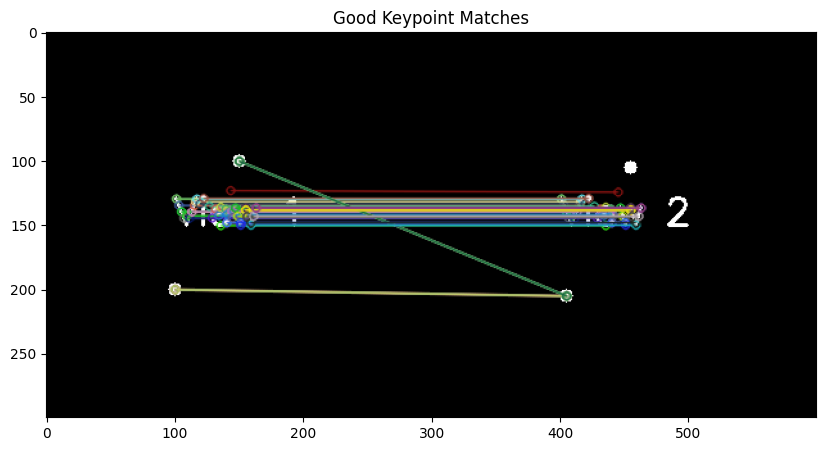

Structure from Motion Task[cite: 8, 9]: Basic steps (feature matching, F/E matrix) outlined.


In [ ]:
# --- Structure from Motion (Simplified Two-View Example) ---
# Requires two images from slightly different viewpoints ('sfm1.jpg', 'sfm2.jpg')

# Load images (replace with your paths)
img1_path = '/content/left.jpg'
img2_path = '/content/sitich.jpeg'
img1 = cv2.imread(img1_path, cv2.IMREAD_GRAYSCALE) # Load as grayscale
img2 = cv2.imread(img2_path, cv2.IMREAD_GRAYSCALE)


# Placeholder: Use the dummy images from stitching if real ones aren't available
if 'img1' not in locals() or 'img2' not in locals() or img1 is None or img2 is None:
    print("Using dummy images for SfM feature matching demo.")
    img1_sfm = np.zeros((300, 300), dtype=np.uint8); cv2.putText(img1_sfm, 'View 1', (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255), 2)
    img2_sfm = np.zeros((300, 300), dtype=np.uint8); cv2.putText(img2_sfm, 'View 2', (100,150), cv2.FONT_HERSHEY_SIMPLEX, 1, (255), 2)
    # Add some common 'features' for demonstration
    cv2.circle(img1_sfm, (150, 100), 5, (255), -1); cv2.circle(img1_sfm, (100, 200), 5, (255), -1)
    cv2.circle(img2_sfm, (155, 105), 5, (255), -1); cv2.circle(img2_sfm, (105, 205), 5, (255), -1) # Slightly shifted
else:
    # img1_sfm = cv2.cvtColor(img1, cv2.COLOR_BGR2GRAY) # img1 is already grayscale
    # img2_sfm = cv2.cvtColor(img2, cv2.COLOR_BGR2GRAY) # img2 is already grayscale
    img1_sfm = img1  # Assign img1 directly to img1_sfm
    img2_sfm = img2  # Assign img2 directly to img2_sfm


if img1_sfm is None or img2_sfm is None:
    print("Error loading images for SfM. Please provide valid paths.")
else:
    # 1. Detect Keypoints and Descriptors (e.g., SIFT, ORB)
    # Note: SIFT might require opencv-contrib-python
    try:
         sift = cv2.SIFT_create()
         kp1, des1 = sift.detectAndCompute(img1_sfm, None)
         kp2, des2 = sift.detectAndCompute(img2_sfm, None)
    except: # Fallback to ORB if SIFT is not available
         print("SIFT not available, using ORB.")
         orb = cv2.ORB_create()
         kp1, des1 = orb.detectAndCompute(img1_sfm, None)
         kp2, des2 = orb.detectAndCompute(img2_sfm, None)


    # 2. Match Descriptors
    if des1 is not None and des2 is not None and len(des1) > 0 and len(des2) > 0:
        # Use FLANN based matcher or BFMatcher
        # FLANN parameters for SIFT
        # FLANN_INDEX_KDTREE = 1
        # index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
        # search_params = dict(checks=50)
        # flann = cv2.FlannBasedMatcher(index_params,search_params)
        # matches = flann.knnMatch(des1,des2,k=2)

        # BFMatcher for ORB (or SIFT)
        bf = cv2.BFMatcher(cv2.NORM_L2 if 'sift' in locals() else cv2.NORM_HAMMING, crossCheck=False) # Use NORM_HAMMING for ORB
        matches = bf.knnMatch(des1, des2, k=2)


        # Apply Lowe's ratio test to find good matches
        good_matches = []
        pts1 = []
        pts2 = []
        for m, n in matches:
            if m.distance < 0.75 * n.distance: # Ratio test
                good_matches.append(m)
                pts1.append(kp1[m.queryIdx].pt)
                pts2.append(kp2[m.trainIdx].pt)

        pts1 = np.int32(pts1)
        pts2 = np.int32(pts2)

        # 3. Estimate Fundamental Matrix [cite: 9]
        if len(good_matches) > 8: # Need at least 8 points for findFundamentalMat
            F, mask_F = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC) # Or cv2.FM_LMEDS

            # Select only inlier points
            pts1_inliers = pts1[mask_F.ravel() == 1]
            pts2_inliers = pts2[mask_F.ravel() == 1]

            print("Fundamental Matrix calculated.")

            # 4. Estimate Essential Matrix (Requires Camera Intrinsics K) [cite: 9]
            # Placeholder Camera Matrix (replace with your actual K)
            K = np.array([[1000, 0, img1_sfm.shape[1]/2],
                          [0, 1000, img1_sfm.shape[0]/2],
                          [0, 0, 1]])

            if F is not None:
               E, mask_E = cv2.findEssentialMat(pts1_inliers, pts2_inliers, K, method=cv2.RANSAC, prob=0.999, threshold=1.0)
               print("Essential Matrix calculated (using placeholder K).")

               # 5. Recover Pose (Rotation R and Translation t)
               # This gives camera 2's pose relative to camera 1
               if E is not None:
                  _, R, t, mask_pose = cv2.recoverPose(E, pts1_inliers, pts2_inliers, K)
                  print("Pose (R, t) recovered.")
                  # Further steps would involve triangulation to get 3D points
               else:
                  print("Could not calculate Essential Matrix.")
            else:
                print("Could not calculate Fundamental Matrix.")

        else:
            print(f"Not enough good matches found - {len(good_matches)}/{8}")

        # Draw matches (optional)
        img_matches = cv2.drawMatches(img1_sfm, kp1, img2_sfm, kp2, good_matches, None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
        plt.figure(figsize=(15, 5))
        plt.imshow(img_matches)
        plt.title('Good Keypoint Matches')
        plt.show()

    else:
        print("Could not find keypoints or descriptors in one or both images.")


print("Structure from Motion Task[cite: 8, 9]: Basic steps (feature matching, F/E matrix) outlined.")
# Full SfM is significantly more involved, often using libraries like COLMAP or OpenMVG.
# For further help:
# https://imkavwu.github.io/tutorials/sfm/
# https://learnopencv.com/mast3r-sfm-grounding-image-matching-3d/

Setting up Autoencoder for Image Restoration [cite: 10]
11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 64)       │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 14, 14, 32)     │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 1)      │           289 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 74,497 (291.00 KB)

 Trainable params: 74,497 (291.00 KB)

 Non-trainable params: 0 (0.00 B)

Training Autoencoder...
Epoch 1/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 11s 13ms/step - loss: 0.1183 - val_loss: 0.1140
Epoch 2/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 3/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 4/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 5/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1123 - val_loss: 0.1140
Epoch 6/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1119 - val_loss: 0.1140
Epoch 7/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 7ms/step - loss: 0.1118 - val_loss: 0.1140
Epoch 8/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 6ms/step - loss: 0.1117 - val_loss: 0.1140
Epoch 9/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 10/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 5s 7ms/step - loss: 0.1121 - val_loss: 0.1140
Epoch 11/50
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 0.1120 - val_loss: 0.1140
Epoch 12/50
469/469 ━━━━━━

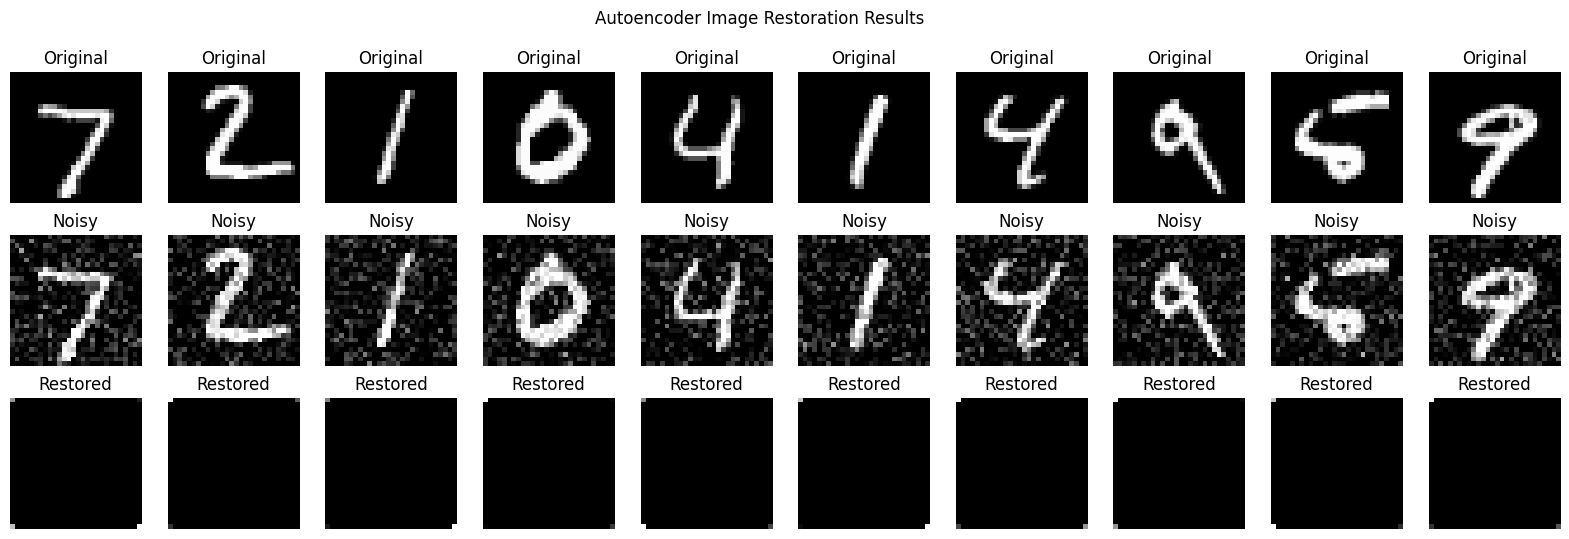

In [ ]:
# --- Image Restoration using Autoencoder ---
print("Setting up Autoencoder for Image Restoration [cite: 10]")

# Step 1: Load & Preprocess Data (MNIST) [cite: 10, 11]
(x_train, _), (x_test, _) = mnist.load_data()

# Normalize and reshape
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.
x_train = np.reshape(x_train, (len(x_train), 28, 28, 1))
x_test = np.reshape(x_test, (len(x_test), 28, 28, 1))

# Step 2: Simulate Degradation (Add Gaussian Noise) [cite: 12]
noise_factor = 0.2 # Adjust noise level
x_train_noisy = x_train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_train.shape)
x_test_noisy = x_test + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=x_test.shape)

# Clip values to be between 0 and 1
x_train_noisy = np.clip(x_train_noisy, 0., 1.)
x_test_noisy = np.clip(x_test_noisy, 0., 1.)

# Step 3: Build the Autoencoder Model [cite: 13, 14]
input_img = Input(shape=(28, 28, 1))

# Encoder
x = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
x = layers.MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(64, (3, 3), activation='relu', padding='same')(x)
encoded = layers.MaxPooling2D((2, 2), padding='same')(x) # Compressed representation

# Decoder
x = Conv2D(64, (3, 3), activation='relu', padding='same')(encoded)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x) # Output shape same as input

autoencoder = Model(input_img, decoded)
autoencoder.compile(optimizer='adam', loss='mean_squared_error') # [cite: 16] Adam optimizer, MSE loss
autoencoder.summary()

# Step 4: Train the Model [cite: 15]
print("Training Autoencoder...")
history = autoencoder.fit(x_train_noisy, x_train, # Noisy as input, original as target
                          epochs=50, # Use more epochs for better results (e.g., 30-50)
                          batch_size=128,
                          shuffle=True,
                          validation_data=(x_test_noisy, x_test))
print("Training complete.")

# Step 5: Image Restoration & Evaluation [cite: 17, 18]
print("Restoring test images...")
decoded_imgs = autoencoder.predict(x_test_noisy)

# Calculate PSNR (Peak Signal-to-Noise Ratio) [cite: 18]
# Note: TF has tf.image.psnr
psnr_values = tf.image.psnr(x_test, decoded_imgs, max_val=1.0)
mean_psnr = np.mean(psnr_values)
print(f"Mean PSNR on test set: {mean_psnr:.4f}")


# Display original, noisy, and restored images
n = 10 # Number of digits to display
plt.figure(figsize=(20, 6))
for i in range(n):
    # Display original
    ax = plt.subplot(3, n, i + 1)
    plt.imshow(x_test[i].reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis("off")

    # Display noisy input
    ax = plt.subplot(3, n, i + 1 + n)
    plt.imshow(x_test_noisy[i].reshape(28, 28), cmap='gray')
    plt.title("Noisy")
    plt.axis("off")

    # Display reconstruction
    ax = plt.subplot(3, n, i + 1 + 2*n)
    plt.imshow(decoded_imgs[i].reshape(28, 28), cmap='gray')
    plt.title("Restored")
    plt.axis("off")
plt.suptitle("Autoencoder Image Restoration Results")
plt.show()

In [ ]:
# --- GAN on MNIST and CIFAR-10 ---
print("Setting up GAN for MNIST/CIFAR-10 Generation [cite: 18]")

# --- Configuration ---
BUFFER_SIZE = 60000
BATCH_SIZE = 256
EPOCHS = 50 # Minimum 50 epochs required [cite: 19]
LATENT_DIM = 100 # Dimensionality of the noise vector
DATASET = 'mnist' # Change to 'cifar10' for the other dataset

# --- Load Data ---
if DATASET == 'mnist':
    (train_images, train_labels), (_, _) = mnist.load_data()
    IMG_SHAPE = (28, 28, 1)
    train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1, 1]
elif DATASET == 'cifar10':
    (train_images, train_labels), (_, _) = cifar10.load_data()
    IMG_SHAPE = (32, 32, 3)
    train_images = train_images.reshape(train_images.shape[0], 32, 32, 3).astype('float32')
    train_images = (train_images - 127.5) / 127.5 # Normalize images to [-1, 1]
else:
    raise ValueError("Dataset must be 'mnist' or 'cifar10'")

train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)


Setting up GAN for MNIST/CIFAR-10 Generation [cite: 18]


In [ ]:
# --- Build Generator (Example DCGAN structure) ---
def make_generator_model(output_shape):
    model = Sequential(name='Generator')
    # Start with Dense layer
    if DATASET == 'mnist':
        model.add(Dense(7*7*256, use_bias=False, input_shape=(LATENT_DIM,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((7, 7, 256)))
        start_shape = (7, 7, 128)
    else: # cifar10
        model.add(Dense(4*4*512, use_bias=False, input_shape=(LATENT_DIM,)))
        model.add(BatchNormalization())
        model.add(LeakyReLU())
        model.add(Reshape((4, 4, 512)))
        start_shape = (4, 4, 256)


    model.add(Conv2DTranspose(start_shape[2], (5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(start_shape[2]//2, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # Upsample
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    model.add(Conv2DTranspose(start_shape[2]//4, (5, 5), strides=(2, 2), padding='same', use_bias=False)) # Upsample
    model.add(BatchNormalization())
    model.add(LeakyReLU())

    # Final layer to match output shape
    model.add(Conv2DTranspose(output_shape[-1], (5, 5), strides=(1, 1), padding='same', use_bias=False, activation='tanh')) # Output [-1, 1]

    return model

generator = make_generator_model(IMG_SHAPE)
generator.summary()

# --- Build Discriminator (Example DCGAN structure) ---
def make_discriminator_model(input_shape):
    model = Sequential(name='Discriminator')
    model.add(Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=input_shape))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    model.add(Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(LeakyReLU())
    model.add(Dropout(0.3))

    if DATASET == 'cifar10': # Add extra layer for larger CIFAR images
         model.add(Conv2D(256, (5, 5), strides=(2, 2), padding='same'))
         model.add(LeakyReLU())
         model.add(Dropout(0.3))

    model.add(Flatten())
    model.add(Dense(1)) # Output a single scalar (real/fake probability)

    return model

discriminator = make_discriminator_model(IMG_SHAPE)
discriminator.summary()


# --- Loss Functions and Optimizers ---
cross_entropy = BinaryCrossentropy(from_logits=True)

def discriminator_loss(real_output, fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output), real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    # Generator wants discriminator to think fake images are real
    return cross_entropy(tf.ones_like(fake_output), fake_output)

generator_optimizer = Adam(1e-4)
discriminator_optimizer = Adam(1e-4)

# --- Checkpoints (Optional but Recommended) ---
# checkpoint_dir = './training_checkpoints_gan'
# checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
# checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
#                                  discriminator_optimizer=discriminator_optimizer,
#                                  generator=generator,
#                                  discriminator=discriminator)

Model: "Generator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 12544)          │     1,254,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 12544)          │        50,176 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_6 (LeakyReLU)       │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ reshape_1 (Reshape)             │ (None, 7, 7, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_4              │ (None, 7, 7, 128)      │       819,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 7, 7, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_7 (LeakyReLU)       │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_5              │ (None, 14, 14, 64)     │       204,800 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 14, 14, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_8 (LeakyReLU)       │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_6              │ (None, 28, 28, 32)     │        51,200 │
│ (Conv2DTranspose)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 28, 28, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_9 (LeakyReLU)       │ (None, 28, 28, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_transpose_7              │ (None, 28, 28, 1)      │           800 │
│ (Conv2DTranspose)               │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,381,472 (9.08 MB)

 Trainable params: 2,355,936 (8.99 MB)

 Non-trainable params: 25,536 (99.75 KB)

Model: "Discriminator"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 64)     │         1,664 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_10 (LeakyReLU)      │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 14, 14, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 128)      │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_11 (LeakyReLU)      │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 7, 7, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 6272)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │         6,273 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

Starting GAN training for 50 epochs on MNIST...
Epoch 5/50, Gen Loss: 0.8194, Disc Loss: 1.3441
Epoch 10/50, Gen Loss: 0.8326, Disc Loss: 1.3001
Epoch 15/50, Gen Loss: 0.9624, Disc Loss: 1.2242
Epoch 20/50, Gen Loss: 1.1279, Disc Loss: 1.1450
Epoch 25/50, Gen Loss: 1.1584, Disc Loss: 1.0800
Epoch 30/50, Gen Loss: 1.0881, Disc Loss: 1.1359
Epoch 35/50, Gen Loss: 0.9523, Disc Loss: 1.2347
Epoch 40/50, Gen Loss: 0.9337, Disc Loss: 1.2464
Epoch 45/50, Gen Loss: 0.9418, Disc Loss: 1.2307
Epoch 50/50, Gen Loss: 0.8746, Disc Loss: 1.2776
GAN Training complete.


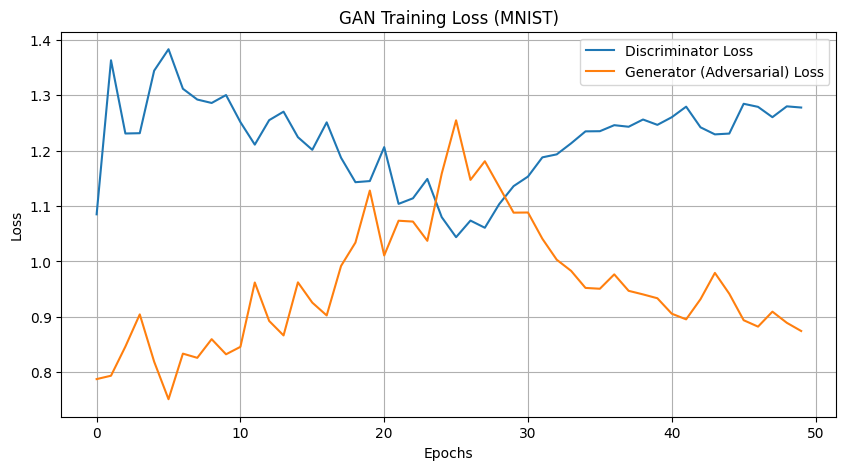

Generating 10 sample images using the trained GAN (MNIST)...


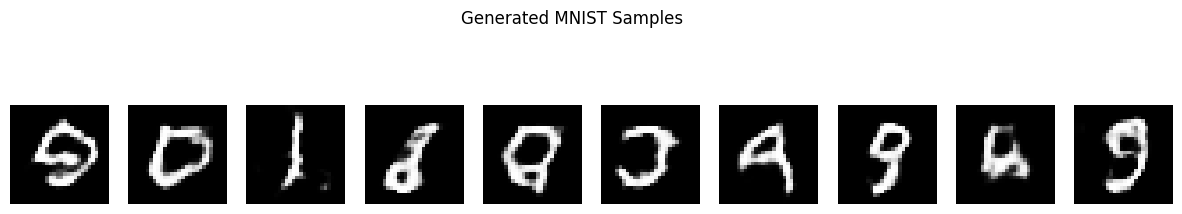

In [ ]:
# --- Training Step ---
@tf.function
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE, LATENT_DIM])

    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise, training=True)

        real_output = discriminator(images, training=True)
        fake_output = discriminator(generated_images, training=True)

        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return gen_loss, disc_loss


# --- Training Loop ---
print(f"Starting GAN training for {EPOCHS} epochs on {DATASET.upper()}...")
gen_loss_history = []
disc_loss_history = []

for epoch in range(EPOCHS):
    epoch_gen_loss = []
    epoch_disc_loss = []
    for image_batch in train_dataset:
        g_loss, d_loss = train_step(image_batch)
        epoch_gen_loss.append(g_loss.numpy())
        epoch_disc_loss.append(d_loss.numpy())

    avg_gen_loss = np.mean(epoch_gen_loss)
    avg_disc_loss = np.mean(epoch_disc_loss)
    gen_loss_history.append(avg_gen_loss)
    disc_loss_history.append(avg_disc_loss)

    # Print progress (e.g., every 5 epochs)
    if (epoch + 1) % 5 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}, Gen Loss: {avg_gen_loss:.4f}, Disc Loss: {avg_disc_loss:.4f}')
        # Generate and save sample images (optional)
        # seed = tf.random.normal([16, LATENT_DIM]) # Generate 16 samples
        # predictions = generator(seed, training=False)
        # fig = plt.figure(figsize=(4, 4))
        # for i in range(predictions.shape[0]):
        #     plt.subplot(4, 4, i+1)
        #     img_to_show = (predictions[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8) # Scale back to 0-255
        #     if img_to_show.shape[-1] == 1: # Grayscale
        #         plt.imshow(img_to_show[:,:,0], cmap='gray')
        #     else: # Color
        #         plt.imshow(img_to_show)
        #     plt.axis('off')
        # plt.show()

    # Save the model periodically (optional)
    # if (epoch + 1) % 10 == 0:
    #    checkpoint.save(file_prefix = checkpoint_prefix)

print("GAN Training complete.")

# --- Plot Discriminator vs Adversarial (Generator) Loss [cite: 18] ---
plt.figure(figsize=(10, 5))
plt.plot(range(EPOCHS), disc_loss_history, label='Discriminator Loss')
plt.plot(range(EPOCHS), gen_loss_history, label='Generator (Adversarial) Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title(f'GAN Training Loss ({DATASET.upper()})')
plt.legend()
plt.grid(True)
plt.show()

# --- Generate 10 Samples ---
print(f"Generating 10 sample images using the trained GAN ({DATASET.upper()})...")
num_samples_to_generate = 10
seed = tf.random.normal([num_samples_to_generate, LATENT_DIM])
generated_samples = generator(seed, training=False)

plt.figure(figsize=(15, 3 if DATASET=='mnist' else 5))
plt.suptitle(f"Generated {DATASET.upper()} Samples")
for i in range(num_samples_to_generate):
    plt.subplot(1, num_samples_to_generate, i + 1)
    img_to_show = (generated_samples[i, :, :, :] * 127.5 + 127.5).numpy().astype(np.uint8) # Scale back to 0-255
    if img_to_show.shape[-1] == 1: # Grayscale MNIST
        plt.imshow(img_to_show[:,:,0], cmap='gray')
    else: # Color CIFAR-10
        plt.imshow(img_to_show)
    plt.axis('off')
plt.show()


Setting up MobileNet for Dog Breed Classification [cite: 19, 20]
Dataset downloaded and extracted.
Loading dataset...
Found 20580 files belonging to 120 classes.
Using 16464 files for training.
Found 20580 files belonging to 120 classes.
Using 4116 files for validation.
Found 120 classes (dog breeds).

 === Training V1 === 

17225924/17225924 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
--- MobileNetV1 Model ---


Model: "MobileNetV1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide (TrueDivide)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract (Subtract)             │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenet_1.00_224 (Functional) │ (None, 7, 7, 1024)     │     3,228,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │       123,000 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,351,864 (12.79 MB)

 Trainable params: 123,000 (480.47 KB)

 Non-trainable params: 3,228,864 (12.32 MB)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 41s 72ms/step - accuracy: 0.2622 - loss: 3.3530 - val_accuracy: 0.6863 - val_loss: 1.0721
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.6496 - loss: 1.2249 - val_accuracy: 0.7478 - val_loss: 0.8217
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 37s 62ms/step - accuracy: 0.7109 - loss: 0.9773 - val_accuracy: 0.7546 - val_loss: 0.7673
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7392 - loss: 0.8610 - val_accuracy: 0.7575 - val_loss: 0.7578
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 70ms/step - accuracy: 0.7506 - loss: 0.8145 - val_accuracy: 0.7736 - val_loss: 0.7046
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 71ms/step - accuracy: 0.7702 - loss: 0.7475 - val_accuracy: 0.7765 - val_loss: 0.7104
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7819 - loss: 0.6980 - val_accuracy: 0.7770 - val_loss: 0.7292
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 41s 70ms/step - accuracy: 0.7937 - loss: 0.6680 - 

Model: "MobileNetV2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ true_divide_1 (TrueDivide)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ subtract_1 (Subtract)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_1      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 45s 75ms/step - accuracy: 0.4505 - loss: 2.3883 - val_accuracy: 0.8061 - val_loss: 0.6431
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 40s 78ms/step - accuracy: 0.7437 - loss: 0.8510 - val_accuracy: 0.8236 - val_loss: 0.5768
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 38s 71ms/step - accuracy: 0.7739 - loss: 0.7305 - val_accuracy: 0.8195 - val_loss: 0.5714
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.7986 - loss: 0.6677 - val_accuracy: 0.8163 - val_loss: 0.5988
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 37s 73ms/step - accuracy: 0.8122 - loss: 0.6169 - val_accuracy: 0.8197 - val_loss: 0.5823
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8241 - loss: 0.5609 - val_accuracy: 0.8178 - val_loss: 0.5984
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 37s 71ms/step - accuracy: 0.8235 - loss: 0.5508 - val_accuracy: 0.8185 - val_loss: 0.5781
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 44s 78ms/step - accuracy: 0.8363 - loss: 0.5089 - 

Model: "MobileNetV3Small"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_12 (InputLayer)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ data_augmentation (Sequential)  │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ MobileNetV3Small (Functional)   │ (None, 7, 7, 576)      │       939,120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 576)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 576)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 120)            │        69,240 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,008,360 (3.85 MB)

 Trainable params: 69,240 (270.47 KB)

 Non-trainable params: 939,120 (3.58 MB)

Epoch 1/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 39s 64ms/step - accuracy: 0.1898 - loss: 3.6806 - val_accuracy: 0.5833 - val_loss: 1.5757
Epoch 2/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 42s 67ms/step - accuracy: 0.5139 - loss: 1.8101 - val_accuracy: 0.6414 - val_loss: 1.2826
Epoch 3/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 37s 60ms/step - accuracy: 0.5736 - loss: 1.5426 - val_accuracy: 0.6591 - val_loss: 1.1886
Epoch 4/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6019 - loss: 1.4061 - val_accuracy: 0.6642 - val_loss: 1.1399
Epoch 5/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.6282 - loss: 1.3123 - val_accuracy: 0.6664 - val_loss: 1.1191
Epoch 6/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 35s 68ms/step - accuracy: 0.6409 - loss: 1.2600 - val_accuracy: 0.6771 - val_loss: 1.0821
Epoch 7/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 36s 58ms/step - accuracy: 0.6406 - loss: 1.2181 - val_accuracy: 0.6842 - val_loss: 1.0744
Epoch 8/10
515/515 ━━━━━━━━━━━━━━━━━━━━ 42s 60ms/step - accuracy: 0.6529 - loss: 1.1923 - 

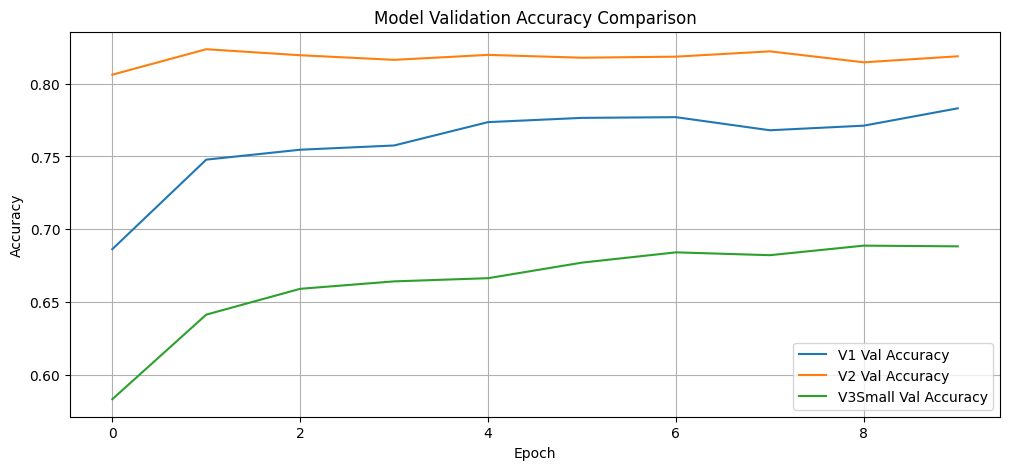

In [ ]:
# --- MobileNet Image Classification on Dog Breeds ---
print("Setting up MobileNet for Dog Breed Classification [cite: 19, 20]")

# --- Configuration ---
IMG_SIZE = (224, 224) # MobileNet input size
BATCH_SIZE_CLS = 32
EPOCHS_CLS = 10 # Adjust as needed
DATASET_URL = "http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar" # Stanford Dogs Dataset


# --- Download and Extract Data (Stanford Dogs) ---
dataset_dir = 'stanford_dogs'
if not os.path.exists(dataset_dir):
    print("Downloading Stanford Dogs dataset...")
    response = requests.get(DATASET_URL, stream=True)
    if response.status_code == 200:
         with tarfile.open(fileobj=response.raw, mode="r|*") as tar:
              tar.extractall(path='.') # Extracts to 'Images' folder
         os.rename('Images', dataset_dir) # Rename folder
         print("Dataset downloaded and extracted.")
    else:
         print(f"Failed to download dataset. Status code: {response.status_code}")
         # Consider using the Kaggle dataset link/API as an alternative [cite: 20]
         print("Please download the dataset manually from Kaggle [cite: 20, 21] or Stanford and place it in the 'stanford_dogs' directory.")

else:
    print("Dataset directory already exists.")


# --- Prepare Dataset using tf.keras.utils.image_dataset_from_directory ---

if os.path.exists(dataset_dir):
    print("Loading dataset...")
    # Split data (e.g., 80% train, 20% validation)
    train_dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        validation_split=0.2,
        subset="training",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE_CLS
    )

    validation_dataset = tf.keras.utils.image_dataset_from_directory(
        dataset_dir,
        validation_split=0.2,
        subset="validation",
        seed=123,
        image_size=IMG_SIZE,
        batch_size=BATCH_SIZE_CLS
    )

    class_names = train_dataset.class_names
    num_classes = len(class_names)
    print(f"Found {num_classes} classes (dog breeds).")

    # --- Configure dataset for performance ---
    AUTOTUNE = tf.data.AUTOTUNE
    train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
    validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)

    # --- Define a function to create and compile the model ---
    def create_mobilenet_model(version='V1', num_classes=num_classes):
        input_shape = IMG_SIZE + (3,)
        # Data augmentation layer (optional but recommended)
        data_augmentation = keras.Sequential(
            [
                layers.RandomFlip("horizontal"),
                layers.RandomRotation(0.1),
                layers.RandomZoom(0.1),
            ],
            name="data_augmentation",
        )

        # Preprocessing layer specific to MobileNet
        if version == 'V1':
            preprocess_input = tf.keras.applications.mobilenet.preprocess_input
            base_model = MobileNet(input_shape=input_shape, include_top=False, weights='imagenet')
            model_name = 'MobileNetV1'
        elif version == 'V2':
            preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
            base_model = MobileNetV2(input_shape=input_shape, include_top=False, weights='imagenet')
            model_name = 'MobileNetV2'
        elif version == 'V3Small':
            preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
            base_model = MobileNetV3Small(input_shape=input_shape, include_top=False, weights='imagenet')
            model_name = 'MobileNetV3Small'
        elif version == 'V3Large':
             preprocess_input = tf.keras.applications.mobilenet_v3.preprocess_input
             base_model = MobileNetV3Large(input_shape=input_shape, include_top=False, weights='imagenet')
             model_name = 'MobileNetV3Large'
        else:
            raise ValueError("Invalid MobileNet version specified")

        # Freeze the base model initially
        base_model.trainable = False

        # Build the full model
        inputs = Input(shape=input_shape)
        x = data_augmentation(inputs) # Apply augmentation
        x = preprocess_input(x) # Apply MobileNet preprocessing
        x = base_model(x, training=False) # Run base model in inference mode
        x = GlobalAveragePooling2D()(x)
        x = Dropout(0.2)(x) # Regularization
        outputs = Dense(num_classes, activation='softmax')(x) # Final classification layer
        model = Model(inputs, outputs, name=model_name)

        # Compile the model
        model.compile(optimizer=Adam(learning_rate=0.001), # Example hyperparameter
                      loss='sparse_categorical_crossentropy',
                      metrics=['accuracy'])
        print(f"--- {model_name} Model ---")
        model.summary()
        return model

    # --- Train and Evaluate Each Version [cite: 20] ---
    results = {}
    # Using Small V3 as V3 example
    versions_to_compare = ['V1', 'V2', 'V3Small'] # Add 'V3Large' if desired

    for version in versions_to_compare:
        print(f"\n === Training {version} === \n")
        model = create_mobilenet_model(version=version, num_classes=num_classes)

        # Train the model (fine-tuning can be added later)
        history = model.fit(train_dataset,
                            epochs=EPOCHS_CLS,
                            validation_data=validation_dataset)

        # Evaluate
        loss, accuracy = model.evaluate(validation_dataset)
        results[version] = {'loss': loss, 'accuracy': accuracy, 'history': history}
        print(f"\n{version} Evaluation - Loss: {loss:.4f}, Accuracy: {accuracy:.4f}")

    # --- Compare Performance [cite: 20] ---
    print("\n === Performance Comparison === ")
    for version, metrics in results.items():
        print(f"{version}: Accuracy = {metrics['accuracy']:.4f}")

    # Plot training history (optional)
    plt.figure(figsize=(12, 5))
    for version, metrics in results.items():
        plt.plot(metrics['history'].history['val_accuracy'], label=f'{version} Val Accuracy')
    plt.title('Model Validation Accuracy Comparison')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend()
    plt.grid(True)
    plt.show()

else:
    print("Cannot proceed with MobileNet classification: Dataset directory not found.")




Setting up U-Net for Pet Segmentation [cite: 21]
images.tar.gz downloaded and extracted.
Images extracted.
annotations.tar.gz downloaded and extracted.
Annotations extracted.
Filtered to 7390 matching image/mask pairs.
Training samples: 6282, Validation samples: 1108


Model: "UNet"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_14      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 128, 128,  │        448 │ input_layer_14[0… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, 128, 128,  │          0 │ conv2d_9[0][0]    │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 128, 128,  │      2,320 │ dropout_7[0][0]   │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 64, 64,    │          0 │ conv2d_10[0][0]   │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 64, 64,    │      4,640 │ max_pooling2d_2[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, 64, 64,    │          0 │ conv2d_11[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 64, 64,    │      9,248 │ dropout_8[0][0]   │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_3     │ (None, 32, 32,    │          0 │ conv2d_12[0][0]   │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_13 (Conv2D)  │ (None, 32, 32,    │     18,496 │ max_pooling2d_3[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_9 (Dropout) │ (None, 32, 32,    │          0 │ conv2d_13[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_14 (Conv2D)  │ (None, 32, 32,    │     36,928 │ dropout_9[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (None, 16, 16,    │          0 │ conv2d_14[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_15 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_4[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_10          │ (None, 16, 16,    │          0 │ conv2d_15[0][0]   │
│ (Dropout)           │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_16 (Conv2D)  │ (None, 16, 16,    │    147,584 │ dropout_10[0][0]  │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_transpose_8  │ (None, 32, 32,    │     32,832 │ conv2d_16[0][0] 

 Total params: 482,033 (1.84 MB)

 Trainable params: 482,033 (1.84 MB)

 Non-trainable params: 0 (0.00 B)

Training U-Net model...
Epoch 1/15


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_745']
Received: inputs=Tensor(shape=(None, 128, 128, 3))
  warnings.warn(msg)


393/393 ━━━━━━━━━━━━━━━━━━━━ 52s 89ms/step - dice_coefficient: 0.1699 - iou_metric: 0.1212 - loss: 0.5627 - val_dice_coefficient: 0.5839 - val_iou_metric: 0.4287 - val_loss: 0.4207
Epoch 2/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 24s 61ms/step - dice_coefficient: 0.5793 - iou_metric: 0.4314 - loss: 0.4740 - val_dice_coefficient: 0.6293 - val_iou_metric: 0.4774 - val_loss: 0.4100
Epoch 3/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 39s 55ms/step - dice_coefficient: 0.6317 - iou_metric: 0.4829 - loss: 0.4361 - val_dice_coefficient: 0.6484 - val_iou_metric: 0.5002 - val_loss: 0.3880
Epoch 4/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 22s 55ms/step - dice_coefficient: 0.6437 - iou_metric: 0.4973 - loss: 0.4283 - val_dice_coefficient: 0.6609 - val_iou_metric: 0.5151 - val_loss: 0.3771
Epoch 5/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 20s 51ms/step - dice_coefficient: 0.6726 - iou_metric: 0.5285 - loss: 0.4018 - val_dice_coefficient: 0.6695 - val_iou_metric: 0.5236 - val_loss: 0.3539
Epoch 6/15
393/393 ━━━━━━━━━━━━━━━━━━━━ 21s 54ms/st

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_745']
Received: inputs=Tensor(shape=(16, 128, 128, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step


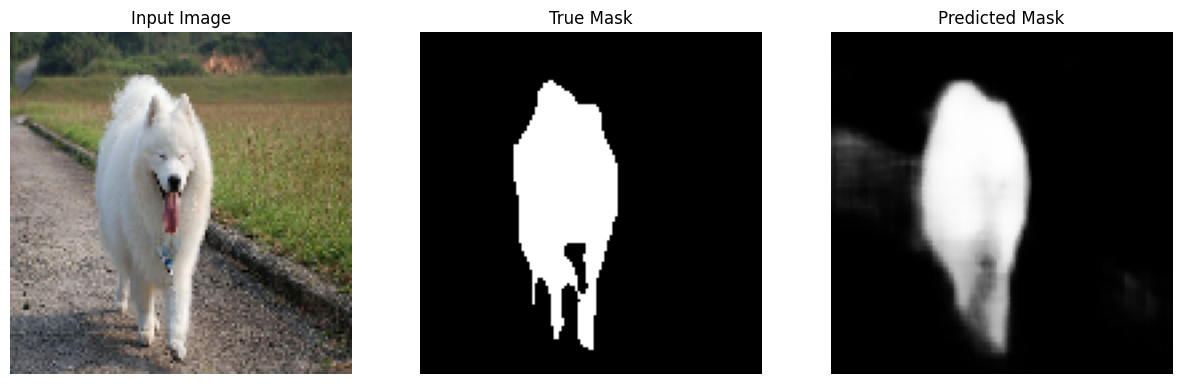

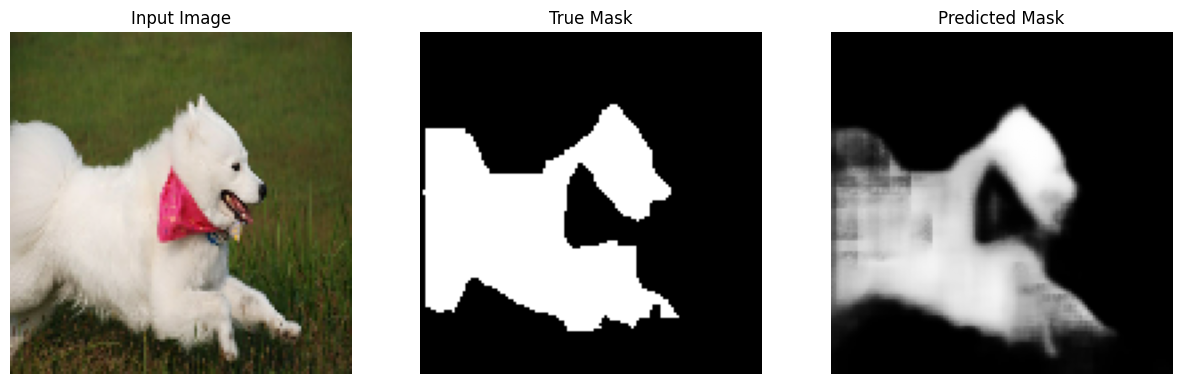

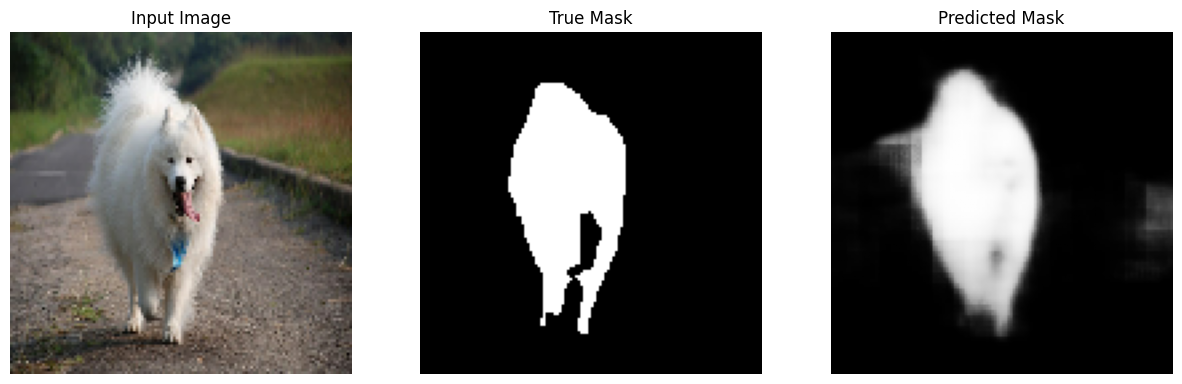

In [ ]:
# --- U-Net for Image Segmentation ---
print("Setting up U-Net for Pet Segmentation [cite: 21]")

# --- Configuration ---
IMG_WIDTH_SEG = 128
IMG_HEIGHT_SEG = 128
IMG_CHANNELS_SEG = 3
BATCH_SIZE_SEG = 16
EPOCHS_SEG = 15 # Adjust as needed
# Dataset URL [cite: 22]
DATASET_URL_PETS = 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/images.tar.gz'
ANNOTATIONS_URL_PETS = 'https://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz'
dataset_dir_pets = 'pets_dataset'
images_dir = os.path.join(dataset_dir_pets, 'images')
masks_dir = os.path.join(dataset_dir_pets, 'annotations', 'trimaps')

# --- Download and Extract Data (Oxford Pets) ---
def download_and_extract(url, download_dir='.'):
    filename = url.split('/')[-1]
    filepath = os.path.join(download_dir, filename)
    if not os.path.exists(filepath.replace('.tar.gz','')):
        print(f"Downloading {filename}...")
        response = requests.get(url, stream=True)
        if response.status_code == 200:
            with tarfile.open(fileobj=response.raw, mode="r|gz") as tar:
                tar.extractall(path=download_dir)
            print(f"{filename} downloaded and extracted.")
            # Special handling for annotations structure
            if 'annotations' in filename and os.path.exists(os.path.join(download_dir, 'annotations')):
                 print("Annotations extracted.")
            elif 'images' in filename and os.path.exists(os.path.join(download_dir, 'images')):
                 print("Images extracted.")
            else:
                 # Try renaming if extracted to default folder name
                 default_folder = filename.replace('.tar.gz','')
                 if os.path.exists(os.path.join(download_dir, default_folder)):
                      print(f"Renaming {default_folder} directory may be needed manually or adjust paths.")
                      # os.rename(os.path.join(download_dir, default_folder), desired_path)

        else:
            print(f"Failed to download {filename}. Status code: {response.status_code}")
            return False
    else:
         print(f"{filename} data already exists.")
    return True


os.makedirs(dataset_dir_pets, exist_ok=True)
images_ok = download_and_extract(DATASET_URL_PETS, dataset_dir_pets)
annotations_ok = download_and_extract(ANNOTATIONS_URL_PETS, dataset_dir_pets)


# --- Prepare Data Paths and Load Data ---
if images_ok and annotations_ok and os.path.exists(images_dir) and os.path.exists(masks_dir):
    image_files = sorted([os.path.join(images_dir, fname) for fname in os.listdir(images_dir) if fname.endswith('.jpg')])
    mask_files = sorted([os.path.join(masks_dir, fname) for fname in os.listdir(masks_dir) if fname.endswith('.png')])

    # Simple check if counts match (basic validation)
    if len(image_files) != len(mask_files):
        print("Warning: Number of images and masks doesn't match!")
        # Attempt to filter based on base names
        img_basenames = set(os.path.splitext(os.path.basename(f))[0] for f in image_files)
        mask_basenames = set(os.path.splitext(os.path.basename(f))[0] for f in mask_files)
        common_basenames = img_basenames.intersection(mask_basenames)
        image_files = sorted([f for f in image_files if os.path.splitext(os.path.basename(f))[0] in common_basenames])
        mask_files = sorted([f for f in mask_files if os.path.splitext(os.path.basename(f))[0] in common_basenames])
        print(f"Filtered to {len(image_files)} matching image/mask pairs.")


    # Split data
    val_samples = int(len(image_files) * 0.15) # 15% for validation
    train_image_files, val_image_files = image_files[:-val_samples], image_files[-val_samples:]
    train_mask_files, val_mask_files = mask_files[:-val_samples], mask_files[-val_samples:]

    print(f"Training samples: {len(train_image_files)}, Validation samples: {len(val_image_files)}")


    # --- Data Generator ---
    def load_and_preprocess_image(path):
        image = tf.io.read_file(path)
        image = tf.image.decode_jpeg(image, channels=3)
        image = tf.image.resize(image, [IMG_HEIGHT_SEG, IMG_WIDTH_SEG])
        image = image / 255.0 # Normalize to [0, 1]
        return image

    def load_and_preprocess_mask(path):
        mask = tf.io.read_file(path)
        mask = tf.image.decode_png(mask, channels=1)
        mask = tf.image.resize(mask, [IMG_HEIGHT_SEG, IMG_WIDTH_SEG], method='nearest') # Use nearest neighbor for masks
        # In Oxford Pets: 1: Foreground, 2: Background, 3: Border
        # Map to binary: 0: Background/Border, 1: Foreground
        mask = tf.where(mask == 1, 1, 0)
        mask = tf.cast(mask, tf.float32)
        return mask

    def create_dataset(image_paths, mask_paths):
        image_ds = tf.data.Dataset.from_tensor_slices(image_paths).map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
        mask_ds = tf.data.Dataset.from_tensor_slices(mask_paths).map(load_and_preprocess_mask, num_parallel_calls=tf.data.AUTOTUNE)
        dataset = tf.data.Dataset.zip((image_ds, mask_ds))
        return dataset

    train_ds = create_dataset(train_image_files, train_mask_files).batch(BATCH_SIZE_SEG).prefetch(buffer_size=tf.data.AUTOTUNE)
    val_ds = create_dataset(val_image_files, val_mask_files).batch(BATCH_SIZE_SEG).prefetch(buffer_size=tf.data.AUTOTUNE)


    # --- Build U-Net Model [cite: 21] ---
    # (Using a simplified Keras functional API implementation)
    inputs = Input((IMG_HEIGHT_SEG, IMG_WIDTH_SEG, IMG_CHANNELS_SEG))

    # Contracting Path (Encoder)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(inputs)
    c1 = Dropout(0.1)(c1)
    c1 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c1)
    p1 = layers.MaxPooling2D((2, 2))(c1)

    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p1)
    c2 = Dropout(0.1)(c2)
    c2 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c2)
    p2 = layers.MaxPooling2D((2, 2))(c2)

    # ... Add more blocks (e.g., 64, 128 filters) following the pattern ...
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p2)
    c3 = Dropout(0.2)(c3)
    c3 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c3)
    p3 = layers.MaxPooling2D((2, 2))(c3)


    # Bottleneck
    c_mid = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(p3)
    c_mid = Dropout(0.2)(c_mid)
    c_mid = Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c_mid)

    # Expansive Path (Decoder)
    u6 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c_mid)
    u6 = Concatenate()([u6, c3]) # Skip connection
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u6)
    c6 = Dropout(0.2)(c6)
    c6 = Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c6)

    # ... Add more blocks (e.g., 32, 16 filters) following the pattern ...
    u7 = Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = Concatenate()([u7, c2])
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u7)
    c7 = Dropout(0.1)(c7)
    c7 = Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c7)

    u8 = Conv2DTranspose(16, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = Concatenate()([u8, c1])
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(u8)
    c8 = Dropout(0.1)(c8)
    c8 = Conv2D(16, (3, 3), activation='relu', kernel_initializer='he_normal', padding='same')(c8)


    # Output layer (1 channel for binary segmentation, sigmoid activation)
    outputs = Conv2D(1, (1, 1), activation='sigmoid')(c8)

    unet_model = Model(inputs=[inputs], outputs=[outputs], name='UNet')


    # --- Compile Model with Metrics [cite: 21] ---
    # Define IoU (Intersection over Union) metric - also known as Jaccard Index
    def iou_metric(y_true, y_pred, smooth=1e-6):
         y_pred = tf.cast(y_pred > 0.5, tf.float32) # Binarize prediction
         intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
         union = tf.reduce_sum(y_true,[1,2,3])+tf.reduce_sum(y_pred,[1,2,3])-intersection
         iou = tf.reduce_mean((intersection + smooth) / (union + smooth), axis=0)
         return iou

    # Define Dice Coefficient metric
    def dice_coefficient(y_true, y_pred, smooth=1e-6):
        y_pred = tf.cast(y_pred > 0.5, tf.float32) # Binarize prediction
        intersection = tf.reduce_sum(tf.abs(y_true * y_pred), axis=[1,2,3])
        sum_ = tf.reduce_sum(y_true, axis=[1,2,3]) + tf.reduce_sum(y_pred, axis=[1,2,3])
        dice = tf.reduce_mean((2. * intersection + smooth) / (sum_ + smooth), axis=0)
        return dice

    unet_model.compile(optimizer=Adam(),
                       loss='binary_crossentropy', # Suitable for binary segmentation
                       metrics=[iou_metric, dice_coefficient]) # Include custom metrics
    unet_model.summary()


    # --- Train the Model ---
    print("Training U-Net model...")
    unet_history = unet_model.fit(train_ds,
                                  epochs=EPOCHS_SEG,
                                  validation_data=val_ds)
    print("Training complete.")

    # --- Evaluate the Model [cite: 21] ---
    print("Evaluating U-Net model on validation set...")
    results_unet = unet_model.evaluate(val_ds)
    print(f"Validation Loss: {results_unet[0]:.4f}")
    print(f"Validation IoU: {results_unet[1]:.4f}")
    print(f"Validation Dice Coefficient: {results_unet[2]:.4f}")


    # --- Visualize Predictions (Optional) ---
    def display(display_list):
        plt.figure(figsize=(15, 5))
        title = ['Input Image', 'True Mask', 'Predicted Mask']
        for i in range(len(display_list)):
            plt.subplot(1, len(display_list), i+1)
            plt.title(title[i])
            img_to_show = tf.keras.utils.array_to_img(display_list[i])
            plt.imshow(img_to_show, cmap='gray' if i > 0 else None) # Use gray cmap for masks
            plt.axis('off')
        plt.show()

    print("Displaying sample predictions...")
    for image, mask in val_ds.take(1): # Take one batch from validation set
        pred_mask = unet_model.predict(image)
        for i in range(min(3, image.shape[0])): # Display first 3 samples
            display([image[i], mask[i], pred_mask[i]])


else:
    print("Cannot proceed with U-Net segmentation: Dataset could not be downloaded or paths are incorrect.")
    print(f"Please ensure '{images_dir}' and '{masks_dir}' exist and contain data.")

